In [448]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate Covariate Summary Statistics
`summary_stats.ipynb` generates various summary statistics for the covariates in our dataset, which are reported in the final paper.

This notebook depends on the following files:
- `data/all-covariates.json`: all repository covariates for all collected data
- `data/treated-repo-ids.csv`: all repository ids and their corresponding treatment status
- `data/did-data.csv`: dataset of aggregated values and covariates for each repository


In [318]:
# Specify the covariates file to use
covariates_file = 'all-covariates.json'

# specify the treatments file to use
treatments_file = '../data/treated-repo-ids.csv'

# Specify exact treatment date
treatment_date = '2016-02-17 00:00:00 UTC'


In [231]:
df_raw = pd.read_json(covariates_file)

In [244]:
print(df_raw.columns)
df_raw.head()

print(df_raw['name'])

Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url',
       'description', 'fork', 'url', 'forks_url', 'keys_url',
       'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url',
       'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url',
       'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url',
       'languages_url', 'stargazers_url', 'contributors_url',
       'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url',
       'comments_url', 'issue_comment_url', 'contents_url', 'compare_url',
       'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url',
       'milestones_url', 'notifications_url', 'labels_url', 'releases_url',
       'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url',
       'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size',
       'stargazers_count', 'watchers_count', 'language', 'has_issues',
       'has_projects', 'has_downloads', 'has_wiki', 'has

In [339]:
def filter_language(langs):
    # langs is a dictionary of languages and their bytes
    # we want to return the most used language
    if not langs:
        return 'None'
    else:
        return max(langs, key=langs.get)

def get_age_seconds(age):
    # returns the age of a repo in seconds, as of the treatment date
    return (pd.to_datetime(treatment_date) - pd.to_datetime(age)).total_seconds()


def kb_to_mb(kb):
    # converts kb to megabytes
    return kb / 1024

In [354]:
# opvs are the covariates we are interested in
opvs = ['id', 'name', 'size', 'watchers',
        'forks', 'stargazers_count', 'created_at',
        'license', 'language']
df_filtered = df_raw[opvs]

# get the age of the repo in days
df_filtered['age'] = df_raw['created_at'].apply(get_age_seconds)
# convert the age to days
df_filtered['age_days'] = df_filtered['age'] / (60*60*24)

# convert the size in bytes to megabytes
df_filtered['size_mb'] = df_filtered['size'].apply(kb_to_mb)

# drop rows where age is negative
df_filtered = df_filtered[df_filtered['age'] > 0]

df_final = df_filtered.drop(['created_at', 'age'], axis=1)


/var/folders/16/f2lcjdn174n2mbc1pd7lybzc0000gn/T/ipykernel_45966/3449836300.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age'] = df_raw['created_at'].apply(get_age_seconds)
/var/folders/16/f2lcjdn174n2mbc1pd7lybzc0000gn/T/ipykernel_45966/3449836300.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age_days'] = df_filtered['age'] / (60*60*24)
/var/folders/16/f2lcjdn174n2mbc1pd7lybzc0000gn/T/ipykernel_45966/3449836300.py:13: SettingWithCopyWarning: 
A value is trying to be 

In [438]:
# filter the raw data frame, selecting only repositories of interest
id_treat= pd.read_csv(treatments_file)
print(id_treat.repo_id)

df_final = df_final[df_final['id'].isin(id_treat.repo_id)]

df_final = df_final.drop_duplicates(subset='id', keep='first')


0          8514
1         65252
2        108278
3        143580
4        156018
         ...   
489    44662669
490    45195614
491    45717250
492    45936895
493    48602252
Name: repo_id, Length: 494, dtype: int64


In [440]:
covariates_of_interest = ['Watchers', 'Forks', 'Stars', 'Age (days)', 'Size (MB)']
# get sample summary statistics, and convert to latex
summary = df_final.describe()
# print(summary)
summary.drop(['id', 'size'], axis=1, inplace=True)
summary.drop(['count'], axis=0, inplace=True)
# print(summary.to_latex())
transposed = summary.T

transposed['se'] = transposed['std'] / np.sqrt(len(df_final))
transposed.insert(0, 'Covar', covariates_of_interest)

print(transposed.to_latex(index=False, float_format='%0.0f'))


\begin{tabular}{lrrrrrrrr}
\toprule
Covar & mean & std & min & 25% & 50% & 75% & max & se \\
\midrule
Watchers & 18598 & 32573 & 2 & 2043 & 8236 & 22116 & 384703 & 1485 \\
Forks & 4479 & 8246 & 2 & 583 & 1846 & 4148 & 78317 & 376 \\
Stars & 18598 & 32573 & 2 & 2043 & 8236 & 22116 & 384703 & 1485 \\
Age (days) & 1009 & 600 & 53 & 516 & 887 & 1422 & 2868 & 27 \\
Size (MB) & 294 & 759 & 0 & 30 & 94 & 247 & 7901 & 35 \\
\bottomrule
\end{tabular}



# Perform a Balance Test on Treated and Untreated Groups

In [369]:
# get list of treated repos
treated = []
for i, values in id_treat.iterrows():
    # skip if v is NaT
    if values['treat'] == 0:
        continue
    
    treated.append(values['repo_id'])

print(len(treated))

165


In [372]:
df_w_treatment = pd.merge(df_final, id_treat, left_on='id', right_on='repo_id')


df_treatment = df_w_treatment[df_w_treatment['treat'] == 1]
df_control = df_w_treatment[df_w_treatment['treat'] == 0]
print(len(df_treatment))
# print(df_treatment.head())
print(len(df_control))
# print(df_control.head())

print(len(df_treatment) + len(df_control))

165
329
494


In [376]:
print(df_treatment.describe())

                 id          size       watchers         forks  \
count  1.650000e+02  1.650000e+02     165.000000    165.000000   
mean   1.348359e+07  3.634871e+05   28709.048485   6852.503030   
std    1.198082e+07  6.105980e+05   44137.483206  10010.641011   
min    8.514000e+03  3.610000e+02     204.000000     58.000000   
25%    3.620194e+06  3.557100e+04    5457.000000   1229.000000   
50%    9.306568e+06  1.314460e+05   12460.000000   3154.000000   
75%    2.024939e+07  3.381710e+05   33859.000000   6919.000000   
max    4.860225e+07  4.037080e+06  384703.000000  73731.000000   

       stargazers_count     age_days      size_mb       repo_id  treat  
count        165.000000   165.000000   165.000000  1.650000e+02  165.0  
mean       28709.048485  1072.430654   354.967839  1.348359e+07    1.0  
std        44137.483206   589.195931   596.287067  1.198082e+07    0.0  
min          204.000000    52.712176     0.352539  8.514000e+03    1.0  
25%         5457.000000   629.670914    

In [424]:
# get summary statistics of each group

covariates = ['watchers', 'forks', 'stargazers_count', 'age_days', 'size_mb']
covar_names = ['Watchers', 'Forks', 'Stars', 'age (days)', 'Size (MB)']


t_describe = df_treatment.drop(['size', 'treat', 'repo_id', 'id'], axis=1).describe().drop(['count'], axis=0).T
print(t_describe)
c_describe = df_control.drop(['size', 'treat', 'repo_id', 'id'], axis=1).describe().drop(['count'], axis=0).T

t_describe = t_describe[['mean', 'std']]
t_describe['se'] = t_describe['std'] / np.sqrt(len(df_treatment))
t_describe.drop(['std'], axis=1, inplace=True)

c_describe = c_describe[['mean', 'std']]
c_describe['se'] = c_describe['std'] / np.sqrt(len(df_control))
c_describe.drop(['std'], axis=1, inplace=True)

t_describe.insert(0, 'Covar.', covar_names)
c_describe.insert(0, 'Covar.', covar_names)

print(t_describe.to_latex(index=False, float_format='%.0f'))
print(c_describe.to_latex(index=False, float_format='%.0f'))

print(len(df_treatment))
print(len(df_control))


                          mean           std         min          25%  \
watchers          28709.048485  44137.483206  204.000000  5457.000000   
forks              6852.503030  10010.641011   58.000000  1229.000000   
stargazers_count  28709.048485  44137.483206  204.000000  5457.000000   
age_days           1072.430654    589.195931   52.712176   629.670914   
size_mb             354.967839    596.287067    0.352539    34.737305   

                           50%           75%            max  
watchers          12460.000000  33859.000000  384703.000000  
forks              3154.000000   6919.000000   73731.000000  
stargazers_count  12460.000000  33859.000000  384703.000000  
age_days           1044.130093   1444.220000    2867.902928  
size_mb             128.365234    330.245117    3942.460938  
\begin{tabular}{lrr}
\toprule
Covar. & mean & se \\
\midrule
Watchers & 28709 & 3436 \\
Forks & 6853 & 779 \\
Stars & 28709 & 3436 \\
age (days) & 1072 & 46 \\
Size (MB) & 355 & 46 \\
\bott

In [545]:
# run t test for covariate balance between treatment and control
from scipy.stats import ttest_ind

test_results = []
for covar in covariates:
    t, p = ttest_ind(df_treatment[covar], df_control[covar], nan_policy='omit')
    test_results.append((covar, t, p))

print(pd.DataFrame(test_results, columns=['Covariate', 't', 'p']).to_latex(index=False, float_format='%.2f'))


\begin{tabular}{lrr}
\toprule
Covariate & t & p \\
\midrule
watchers & 5.25 & 0.00 \\
forks & 4.82 & 0.00 \\
stargazers_count & 5.25 & 0.00 \\
age_days & 1.76 & 0.08 \\
size_mb & -0.22 & 0.82 \\
\bottomrule
\end{tabular}



# Get Descriptive Statistics for Issue History Data

In [548]:
did_data_file = '../data/did-data.csv'

did_data = pd.read_csv(did_data_file)

did_data.rename(columns={'count': 'issue_count'}, inplace=True)
print(did_data.head())

print(len(did_data))

   Unnamed: 0  repo_id  time  first_treat  treat  comment_count      ttc_d  \
0           0     8514     1            5      1       3.901532  39.686970   
1           1     8514     2            5      1       3.450549  64.212091   
2           2     8514     3            5      1       3.111801  67.812250   
3           3     8514     4            5      1       3.305714  92.517530   
4           4     8514     5            5      1       4.139806  57.028377   

   issue_count  id  post      y0_1       y0_2      y0_3      y0_4  \
0          457   1     0  39.68697  64.212091  67.81225  92.51753   
1          364   1     0  39.68697  64.212091  67.81225  92.51753   
2          322   1     0  39.68697  64.212091  67.81225  92.51753   
3          350   1     0  39.68697  64.212091  67.81225  92.51753   
4          515   1     1  39.68697  64.212091  67.81225  92.51753   

           age    size  watchers  forks  has_wiki  
0  2867.902928  274356     54624  21238     False  
1  2867.9029

In [592]:
# Generate descriptive statistics
issue_stats = did_data[['ttc_d', 'comment_count']].describe()
print(issue_stats)

# Calculate standard error
issue_stats_ttc_se = issue_stats['ttc_d']['std'] / np.sqrt(len(did_data))
print(issue_stats_ttc_se)

issue_stats_cc_se = issue_stats['comment_count']['std'] / np.sqrt(len(did_data))
print(issue_stats_cc_se)

issue_stats_dropped = issue_stats.drop(['std', 'min', 'max'])

print(issue_stats_dropped.to_latex(float_format='%.2f'))

             ttc_d  comment_count
count  4313.000000    4313.000000
mean     86.816865       3.405110
std      74.037007       1.734578
min       0.043428       0.000000
25%      37.495321       2.359375
50%      69.638206       3.208791
75%     113.998724       4.210938
max     928.142512      37.350000
\begin{tabular}{lrr}
\toprule
 & ttc_d & comment_count \\
\midrule
count & 4313.00 & 4313.00 \\
mean & 86.82 & 3.41 \\
25% & 37.50 & 2.36 \\
50% & 69.64 & 3.21 \\
75% & 114.00 & 4.21 \\
\bottomrule
\end{tabular}



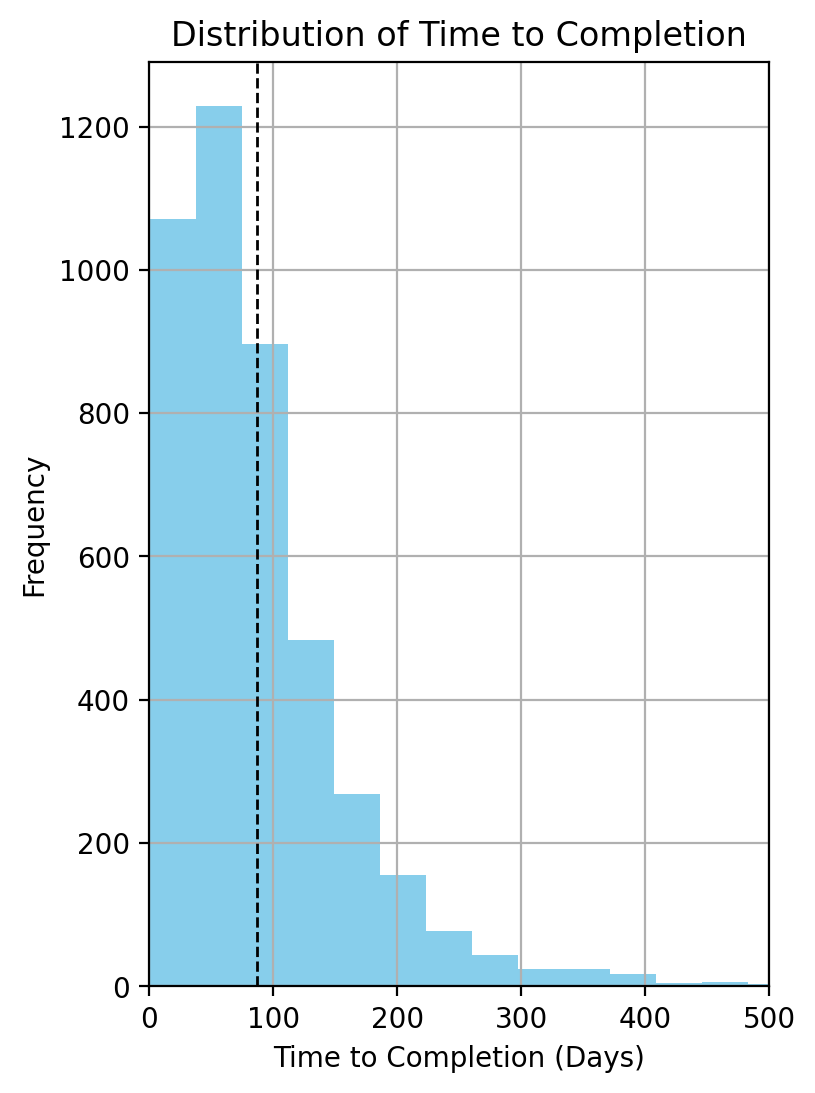

In [561]:
# Plot the distribution
plt.figure(figsize=(4, 6), dpi=200)
plt.hist(did_data['ttc_d'], bins=25, color='skyblue', linewidth=0)
plt.xlabel('Time to Completion (Days)')
plt.ylabel('Frequency')
plt.xlim(0, 500)
plt.title('Distribution of Time to Completion')
plt.grid(True)

plt.axvline(did_data['ttc_d'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()


In [563]:
# Filter data for time = first_treat - 1 and time = first_treat + 1
ttc_d_before_treatment = did_data[did_data['time'] <= did_data['first_treat'] - 1]['ttc_d']
ttc_d_after_treatment = did_data[did_data['time'] > did_data['first_treat']]['ttc_d']

comment_count_before_treatment = did_data[did_data['time'] <= did_data['first_treat'] - 1]['comment_count']
comment_count_after_treatment = did_data[did_data['time'] > did_data['first_treat']]['comment_count']


In [566]:
# get summary statistics of each ttc_d group
ttc_d_before_treatment_stats = ttc_d_before_treatment.describe()
ttc_d_after_treatment_stats = ttc_d_after_treatment.describe()

# compute the standard error
ttc_d_before_treatment_se = ttc_d_before_treatment_stats['std'] / np.sqrt(len(ttc_d_before_treatment))
ttc_d_after_treatment_se = ttc_d_after_treatment_stats['std'] / np.sqrt(len(ttc_d_after_treatment))

#add the standard error to the summary statistics
ttc_d_before_treatment_stats['se'] = ttc_d_before_treatment_se
ttc_d_after_treatment_stats['se'] = ttc_d_after_treatment_se

In [567]:
# get summary statistics of each comment count group
comment_count_before_treatment_stats = comment_count_before_treatment.describe()
comment_count_after_treatment_stats = comment_count_after_treatment.describe()

# compute the standard error
comment_count_before_treatment_se = comment_count_before_treatment_stats['std'] / np.sqrt(len(comment_count_before_treatment))
comment_count_after_treatment_se = comment_count_after_treatment_stats['std'] / np.sqrt(len(comment_count_after_treatment))

# add the standard error to the summary statistics
comment_count_before_treatment_stats['se'] = comment_count_before_treatment_se
comment_count_after_treatment_stats['se'] = comment_count_after_treatment_se


In [570]:
# combine into a single dataframe
ttc_d_stats = pd.DataFrame({'Before Treatment': ttc_d_before_treatment_stats, 'After Treatment': ttc_d_after_treatment_stats})
ttc_d_stats = ttc_d_stats.drop(['std', 'min', 'max'])


comment_count_stats = pd.DataFrame({'Before Treatment': comment_count_before_treatment_stats, 'After Treatment': comment_count_after_treatment_stats})
comment_count_stats = comment_count_stats.drop(['std', 'min', 'max'])

print(ttc_d_stats.to_latex(float_format='%.02f'))

print(comment_count_stats.to_latex(float_format='%.02f'))

\begin{tabular}{lrr}
\toprule
 & Before Treatment & After Treatment \\
\midrule
count & 1725.00 & 2300.00 \\
mean & 93.36 & 82.89 \\
25% & 43.77 & 34.74 \\
50% & 77.63 & 63.61 \\
75% & 121.01 & 109.45 \\
se & 1.77 & 1.57 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
 & Before Treatment & After Treatment \\
\midrule
count & 1725.00 & 2300.00 \\
mean & 3.67 & 3.18 \\
25% & 2.62 & 2.13 \\
50% & 3.45 & 2.99 \\
75% & 4.48 & 3.96 \\
se & 0.04 & 0.04 \\
\bottomrule
\end{tabular}



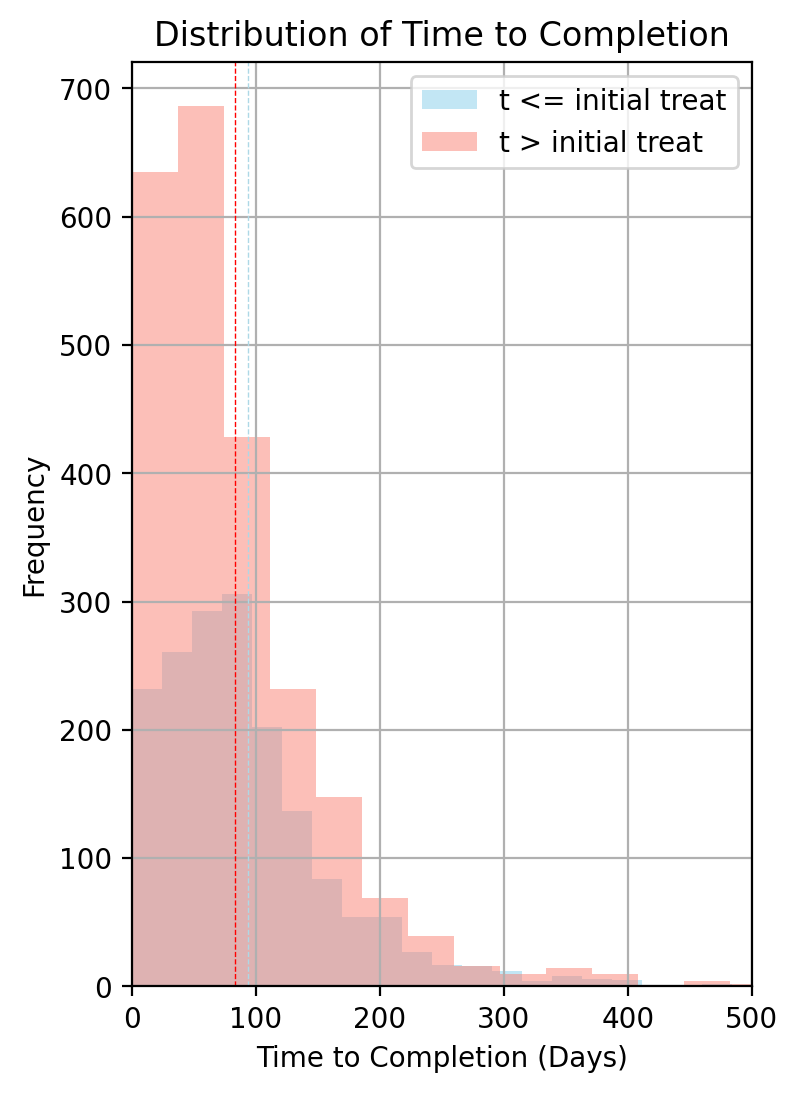

In [511]:


# Plot the distributions
plt.figure(figsize=(4, 6), dpi=200)
plt.hist(ttc_d_before_treatment, bins=25, color='skyblue', alpha=0.5, label='t <= initial treat', linewidth=0.2)
plt.hist(ttc_d_after_treatment, bins=25, color='salmon', alpha=0.5, label='t > initial treat', linewidth=0.2)

plt.axvline(ttc_d_before_treatment.mean(), color='lightblue', linestyle='dashed', linewidth=0.5)
plt.axvline(ttc_d_after_treatment.mean(), color='red', linestyle='dashed', linewidth=0.5)
plt.xlabel('Time to Completion (Days)')
plt.xlim(0, 500)
plt.ylabel('Frequency')
plt.title('Distribution of Time to Completion')
plt.legend()
plt.grid(True)
plt.show()
